In [6]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
import os
from statsmodels import robust
import math
from scipy.stats import linregress

# Variables

In [2]:
archivo = fits.open('Variablesb279.fits')
s_variables=archivo[1].data.tolist()+ archivo[4].data.tolist() + archivo[7].data.tolist()+ archivo[10].data.tolist()
s_variables=np.array(s_variables)
HDJl=archivo[2].data.tolist()
HJD=HDJl[9]
archivo.info()

Filename: Variablesb279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  S1_PERIOD     1 ImageHDU         8   (68, 46)   float64   
  2  HJD1_PERIOD    1 ImageHDU         8   (68, 46)   float64   
  3  E1_PERIOD     1 ImageHDU         8   (68, 46)   float64   
  4  S1_LPV        1 ImageHDU         8   (68, 2)   float64   
  5  HJD1_LPV      1 ImageHDU         8   (68, 2)   float64   
  6  E1_LPV        1 ImageHDU         8   (68, 2)   float64   
  7  S2_PERIOD     1 ImageHDU         8   (68, 53)   float64   
  8  HJD2_PERIOD    1 ImageHDU         8   (68, 53)   float64   
  9  HJD2_PERIOD    1 ImageHDU         8   (68, 53)   float64   
 10  S2_LPV        1 ImageHDU         8   (68, 3)   float64   
 11  HJD2_LPV      1 ImageHDU         8   (68, 3)   float64   
 12  E2_LPV        1 ImageHDU         8   (68, 3)   float64   


# No Variables

In [3]:
archivo1 = fits.open('Medias-Desviacion279.fits')
s_novariables=archivo1[10].data
archivo1.info()

Filename: Medias-Desviacion279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  MEDIAS        1 ImageHDU         7   (1280954,)   float64   
  2  MAD           1 ImageHDU         7   (1280954,)   float64   
  3  KS_NSAT       1 ImageHDU         8   (68, 1223069)   float64   
  4  EKS_NSAT      1 ImageHDU         8   (68, 1223069)   float64   
  5  MEDIASNS      1 ImageHDU         7   (1223069,)   float64   
  6  MADNS         1 ImageHDU         7   (1223069,)   float64   
  7  Q3_EKS        1 ImageHDU         8   (68, 956867)   float64   
  8  Q3_KS         1 ImageHDU         8   (68, 956867)   float64   
  9  EQ3_EKS       1 ImageHDU         8   (68, 956867)   float64   
 10  D3_KS         1 ImageHDU         8   (68, 306755)   float64   
 11  ED3_EKS       1 ImageHDU         8   (68, 306755)   float64   


# 1. MAD

In [5]:
# Función para calcular la Mediana de la Desviación Absoluta (MAD) eliminando valores np.nan
def mad(arr1, arr2):
    mads_arr1 = []
    for sublist in arr1:
        arr_cleaned = [x for x in sublist if not np.isnan(x)]
        if arr_cleaned:  # Verifica que la lista no esté vacía después de eliminar np.nan
            median = np.median(arr_cleaned)
            mad = np.median(np.abs(arr_cleaned - median))
            mads_arr1.append(mad)
    
    mads_arr2 = []
    for sublist in arr2:
        arr_cleaned = [x for x in sublist if not np.isnan(x)]
        if arr_cleaned:  # Verifica que la lista no esté vacía después de eliminar np.nan
            median = np.median(arr_cleaned)
            mad = np.median(np.abs(arr_cleaned - median))
            mads_arr2.append(mad)
    
    return mads_arr1, mads_arr2
# Calcular MAD para los datos
mads_s_variables, mads_s_novariables = mad(s_variables, s_novariables)
print(len(mads_s_variables))
print(len(mads_s_novariables))

104
306755


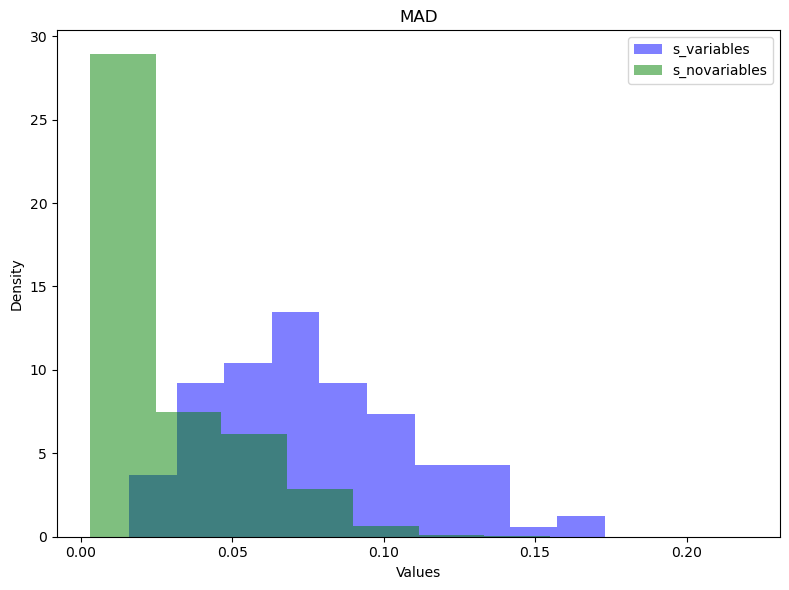

In [6]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(mads_s_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(mads_s_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('MAD')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [8]:
# Calcular la cantidad de objetos en s_novariables antes de la superposición
threshold = np.min(mads_s_variables)  # Se toma el valor mínimo de s_variables como umbral
s_novariables_before_overlap = np.sum(mads_s_novariables < threshold)
print(f'Cantidad de objetos en s_novariables antes de la superposición: {s_novariables_before_overlap}')
print("Se diferencia el 51,48%")

Cantidad de objetos en s_novariables antes de la superposición: 157940
Se diferencia el 51,48%


In [9]:
# Crear un objeto HDU primario vacío
hdu_primary = fits.PrimaryHDU()

# Crear objetos HDU para cada lista de datos
hdu_s_variables = fits.ImageHDU(np.array(mads_s_variables), name='MAD_variables')
hdu_s_novariables = fits.ImageHDU(np.array(mads_s_novariables), name='MAD_novariables')

# Crear un objeto HDUList para contener el HDU primario y los HDU de datos
hdul = fits.HDUList([hdu_primary, hdu_s_variables, hdu_s_novariables])

# Guardar el archivo FITS
hdul.writeto('Features_b279.fits', overwrite=True)

# 2. Mediana

In [10]:
def calcular_mediana_por_objeto(s_variables, s_novariables):
    # Lista para almacenar los resultados
    resultados_variables = []
    resultados_novariables = []

    # Iterar sobre las sub listas en s_variables
    for sublist in s_variables:
        # Filtrar np.nan de la sub lista
        sublist_filtrada = [x for x in sublist if not np.isnan(x)]
        # Calcular la mediana
        mediana = np.median(sublist_filtrada)
        # Agregar la mediana a los resultados
        resultados_variables.append(mediana)

    # Iterar sobre las sub listas en s_novariables
    for sublist in s_novariables:
        # Filtrar np.nan de la sub lista
        sublist_filtrada = [x for x in sublist if not np.isnan(x)]
        # Calcular la mediana
        mediana = np.median(sublist_filtrada)
        # Agregar la mediana a los resultados
        resultados_novariables.append(mediana)

    return resultados_variables, resultados_novariables

resultados_variables, resultados_novariables = calcular_mediana_por_objeto(s_variables, s_novariables)
print(len(resultados_variables))
print(len(resultados_novariables))

104
306755


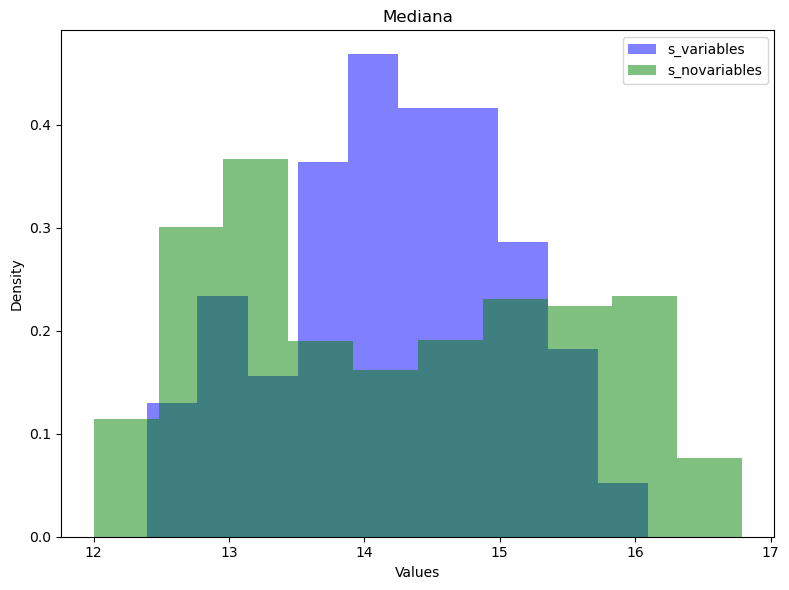

In [34]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('Mediana')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 3. VART

In [33]:
def calcular_VART(sublista, tiempo):
    # Eliminar valores np.nan de la sublista y del tiempo
    sublista_limpia = [valor for valor in sublista if not np.isnan(valor)]
    tiempo_limpio = [t for t, valor in zip(tiempo, sublista) if not np.isnan(valor)]

    # Calcular la mediana de la sublista
    mediana = np.median(sublista_limpia)

    # Calcular el VART según la fórmula
    VART = np.sum(np.abs(np.array(sublista_limpia) - mediana) / np.array(tiempo_limpio))
    return VART


# Calcular VART para cada sublista en s_variables y s_novariables
VART_s_variables = [calcular_VART(sublista, HJD) for sublista in s_variables]
VART_s_novariables = [calcular_VART(sublista, HJD) for sublista in s_novariables]

print(len(VART_s_variables))
print(len(VART_s_novariables))

104
306755


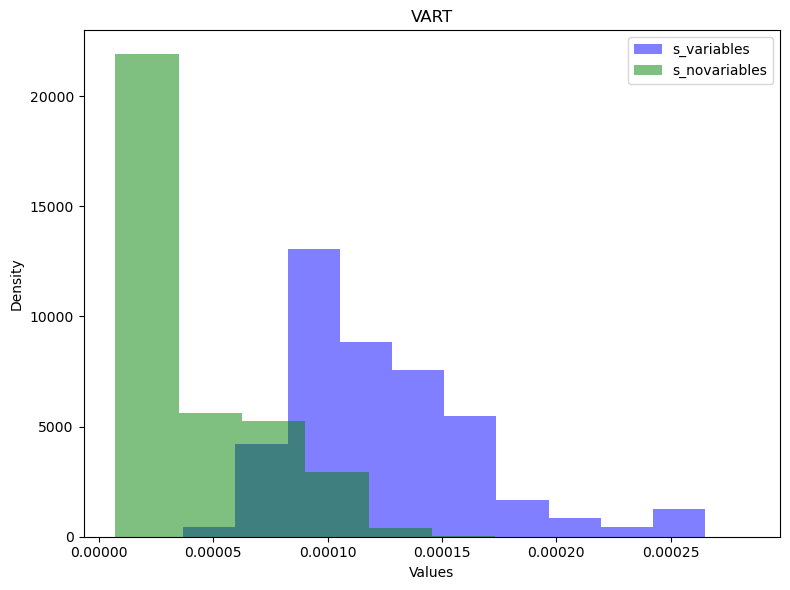

In [35]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(VART_s_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(VART_s_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('VART')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [37]:
# Calcular la cantidad de objetos en s_novariables antes de la superposición
threshold = np.min(VART_s_variables)  # Se toma el valor mínimo de s_variables como umbral
s_novariables_before_overlap = np.sum(VART_s_novariables < threshold)
print(f'Cantidad de objetos en s_novariables antes de la superposición: {s_novariables_before_overlap}')
print("Se diferencia el 62.17%")

Cantidad de objetos en s_novariables antes de la superposición: 190710
Se diferencia el 62.17%


In [38]:
# Convertir las listas de listas a arrays de NumPy
VART_s_variables = np.array(VART_s_variables)
VART_s_novariables = np.array(VART_s_novariables)

# Abrir el archivo FITS existente
hdul = fits.open('Features_b279.fits', mode="append")


# Crear objetos ImageHDU para cada array con sus respectivos nombres
hdu1 = fits.ImageHDU(VART_s_variables, name='VART_v')
hdu2 = fits.ImageHDU(VART_s_novariables, name='VART_nv')

# Agregar los HDUs al HDUList existente
hdul.append(hdu1)
hdul.append(hdu2)

# Guardar el HDUList actualizado en el mismo archivo FITS
#hdul.writeto('Variablesb278.fits', overwrite=True)
hdul.close()
print("Arrays agregados al archivo FITS existente.")

Arrays agregados al archivo FITS existente.


# 4. Factor AV 

In [39]:
def calcular_av(lista):
    # Eliminar np.nan de la lista
    lista_sin_nan = [x for x in lista if not np.isnan(x)]
    
    # Calcular la media de la lista
    media = np.mean(lista_sin_nan)
    
    # Calcular el numerador de la fórmula
    numerador = np.sum(np.diff(lista_sin_nan)**2)
    
    # Calcular el denominador de la fórmula
    denominador = 2 * (len(lista_sin_nan) - 1) * np.sum((lista_sin_nan - media)**2)
    
    # Calcular el valor Abbe
    if denominador != 0:
        av = numerador / denominador
    else:
        av = np.nan
    
    return av

def calcular_av_para_listas_de_listas(lista_de_listas):
    resultados = []
    for sublista in lista_de_listas:
        av = calcular_av(sublista)
        resultados.append(av)
    return resultados

av_s_variables = calcular_av_para_listas_de_listas(s_variables)
av_s_novariables = calcular_av_para_listas_de_listas(s_novariables)

print(len(av_s_variables))
print(len(av_s_novariables))

104
306755


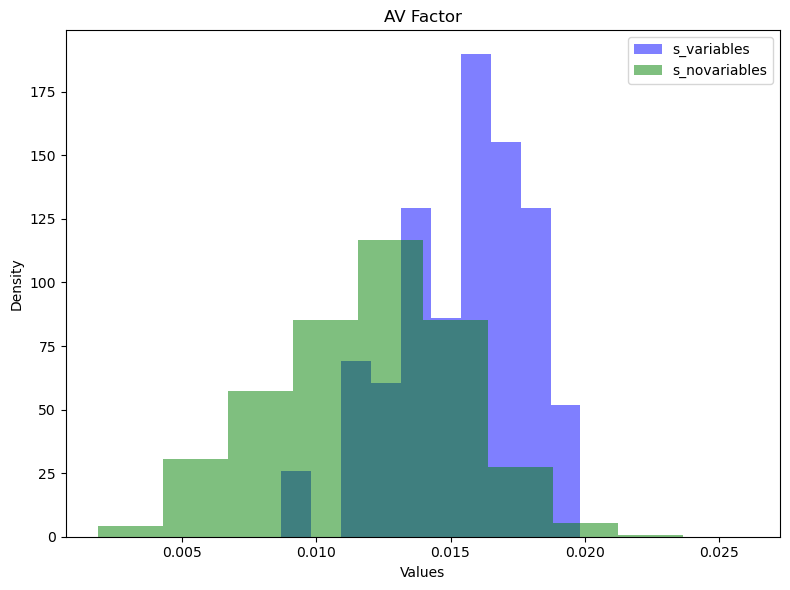

In [40]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(av_s_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(av_s_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('AV Factor')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [42]:
# Calcular la cantidad de objetos en s_novariables antes de la superposición
threshold = np.min(av_s_variables)  # Se toma el valor mínimo de s_variables como umbral
s_novariables_before_overlap = np.sum(av_s_novariables < threshold)
print(f'Cantidad de objetos en s_novariables antes de la superposición: {s_novariables_before_overlap}')
print("Se diferencia el 19,41%")

Cantidad de objetos en s_novariables antes de la superposición: 59545
Se diferencia el 19,41%


# 5. robAbbe

In [5]:
# Función para calcular la M-estimación de Huber
def huber_estimator(data, c=1.345):
    median = np.median(data)
    diff = np.abs(data - median)
    outlier_mask = diff > c * np.median(diff)
    data_clean = data[~outlier_mask]
    return np.median(data_clean), np.median(np.abs(data_clean - np.median(data_clean))) * 1.4826

# Función para calcular el factor de RobAbbe
def calcular_robAbbe(s_variables, s_novariables, c=1.345):
    resultados_s_variables = []
    resultados_s_novariables = []

    for sublist_vars, sublist_novars in zip(s_variables, s_novariables):
        # Eliminar los valores np.nan de las sublistas
        sublist_vars_clean = np.array([x for x in sublist_vars if not np.isnan(x)])
        sublist_novars_clean = np.array([x for x in sublist_novars if not np.isnan(x)])

        # Calcular la M-estimación de Huber para las sublistas
        _, mad_vars = huber_estimator(sublist_vars_clean, c=c)
        _, mad_novars = huber_estimator(sublist_novars_clean, c=c)

        # Calcular el factor de RobAbbe
        robAbbe_vars = mad_vars
        robAbbe_novars = mad_novars

        resultados_s_variables.append(robAbbe_vars)
        resultados_s_novariables.append(robAbbe_novars)

    return resultados_s_variables, resultados_s_novariables


rob_s_variables, rob_s_novariables = calcular_robAbbe(s_variables, s_novariables)


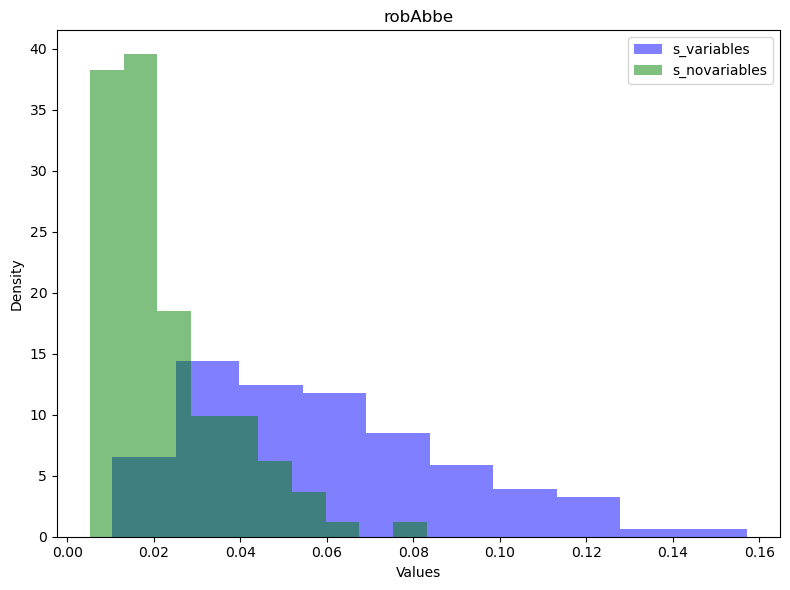

In [6]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(rob_s_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(rob_s_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('robAbbe')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 6. DIFDE

In [8]:
def calcular_DIFDER(X, Y):
    N = len(X)
    DIFDER_resultados = []
    
    for Y_i in Y:
        suma_difder = 0
        count = 0
        
        for i in range(N-2):
            if not (np.isnan(X[i]) or np.isnan(X[i+1]) or np.isnan(X[i+2])):
                numerador1 = Y_i[i] - Y_i[i+1]
                denominador1 = X[i] - X[i+1]
                numerador2 = Y_i[i+1] - Y_i[i+2]
                denominador2 = X[i+1] - X[i+2]

                if denominador1 != 0 and denominador2 != 0:
                    difder = ((numerador1 / denominador1) - (numerador2 / denominador2)) - (numerador1 / denominador1)
                    suma_difder += difder
                    count += 1

        if count != 0:
            DIFDER_resultados.append(suma_difder / count)
        else:
            DIFDER_resultados.append(np.nan)
    
    return DIFDER_resultados


DIFDER_s_variables = calcular_DIFDER(HJD, s_variables)
DIFDER_s_novariables = calcular_DIFDER(HJD, s_novariables)

print(len(DIFDER_s_variables))
print(len(DIFDER_s_novariables))


104
306755


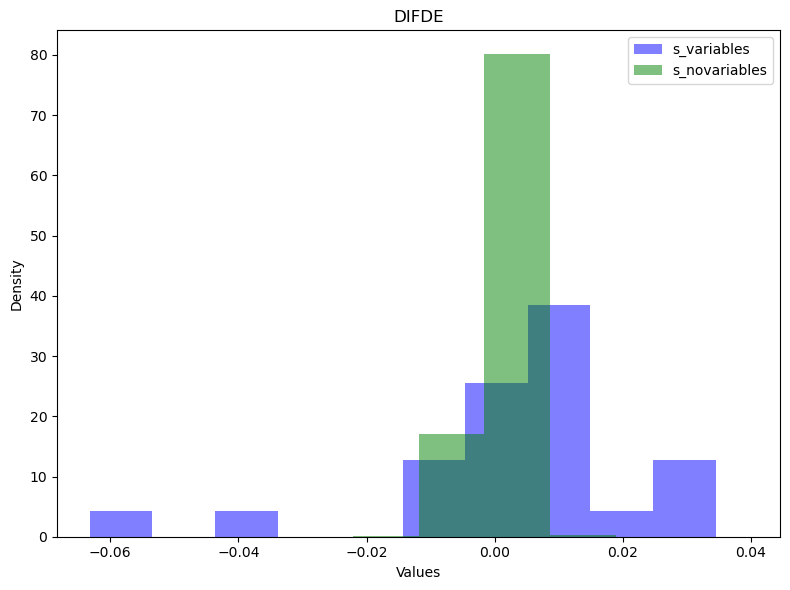

In [11]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(DIFDER_s_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(DIFDER_s_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('DIFDE')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 7. PROY 2

In [16]:
# Función para eliminar los valores nan de una lista
def remove_nan(lst):
    return [x for x in lst if not np.isnan(x)]

# Eliminar los valores nan de las listas en s_variables y guardar en HDJ_variables
variables = [remove_nan(lst) for lst in s_variables]

# No eliminar los valores nan de las listas en s_novariables y guardar en HJD_novariables
novariables = [remove_nan(lst) for lst in s_novariables]

# Función para eliminar np.nan de HJD por cada sublista de s_variables
def remove_nan_in_HJD(HJD, s_variables):
    result = []
    for sublist in s_variables:
        valid_indices = [i for i, val in enumerate(sublist) if not np.isnan(val)]
        result.append([HJD[i] for i in valid_indices])
    return result

# Eliminar np.nan en HJD por cada sublista de s_variables
HJD_variable = remove_nan_in_HJD(HJD, s_variables)
HJD_novariable = remove_nan_in_HJD(HJD, s_novariables)

# Función para calcular la proyección según la fórmula dada
def calcular_proyeccion(X, Y):
    N = len(X)
    proyecciones = []
    for i in range(1, N-1):
        proyeccion = ((Y[i+1] - Y[i-1]) / (X[i+1] - X[i-1])) * (X[i] - X[i-1]) + Y[i-1] - Y[i]
        proyecciones.append(proyeccion)
    return proyecciones

# Calcular proyección para cada sublista y guardar los resultados en una lista
proy_varibles = []
for i in range(len(HJD_variable)):
    X_actual = HJD_variable[i]
    Y_actual = variables[i]
    proyecciones_actual = calcular_proyeccion(X_actual, Y_actual)
    proyeccion_promedio = sum(proyecciones_actual) / len(proyecciones_actual)
    proy_varibles.append(proyeccion_promedio)
    
    
# Calcular proyección para cada sublista y guardar los resultados en una lista
proy_novaribles = []
for j in range(len(HJD_novariable)):
    X_actual = HJD_novariable[j]
    Y_actual = novariables[j]
    proyecciones_actual = calcular_proyeccion(X_actual, Y_actual)
    proyeccion_promedio = sum(proyecciones_actual) / len(proyecciones_actual)
    proy_novaribles.append(proyeccion_promedio)
 


print(len(proy_varibles))
print(len(proy_novaribles))

104
306755


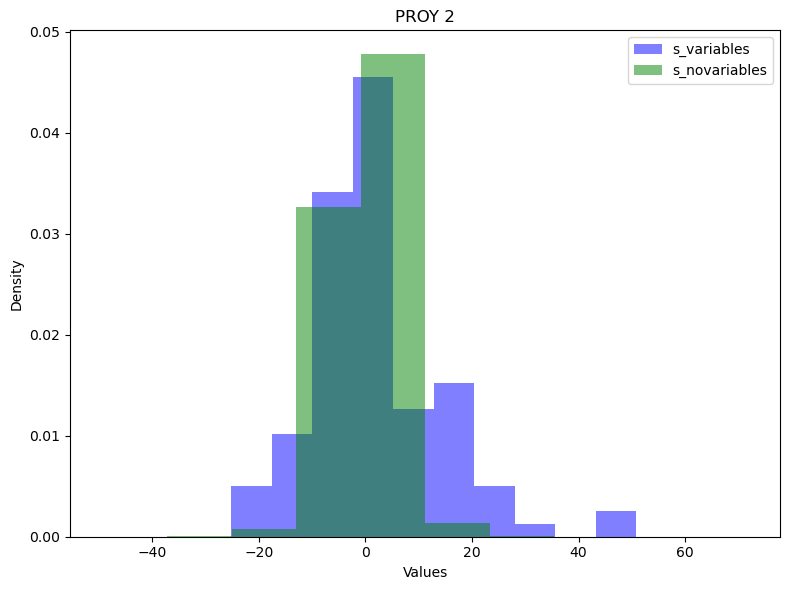

In [17]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(proy_varibles, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(proy_novaribles, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('PROY 2')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 8. INTEGRAL 

In [20]:
def calcular_integral(X, Y):
    N = len(X)
    delta_X = [X[i + 1] - X[i] for i in range(N - 1)]
    mean_Y = sum(Y) / N
    integral = sum([(delta_X[i] * (Y[i] - mean_Y)) for i in range(N - 1)]) / (X[N - 1] - X[0])
    return integral

integrals_variables = []
for i in range(len(HJD_variable)):
    integral = calcular_integral(HJD_variable[i], variables[i])
    integrals_variables.append(abs(integral))
    
    
integrals_novariables = []
for j in range(len(HJD_novariable)):
    integral = calcular_integral(HJD_novariable[j], novariables[j])
    integrals_novariables.append(abs(integral))
    
print(len(integrals_variables))
print(len(integrals_novariables))

104
306755


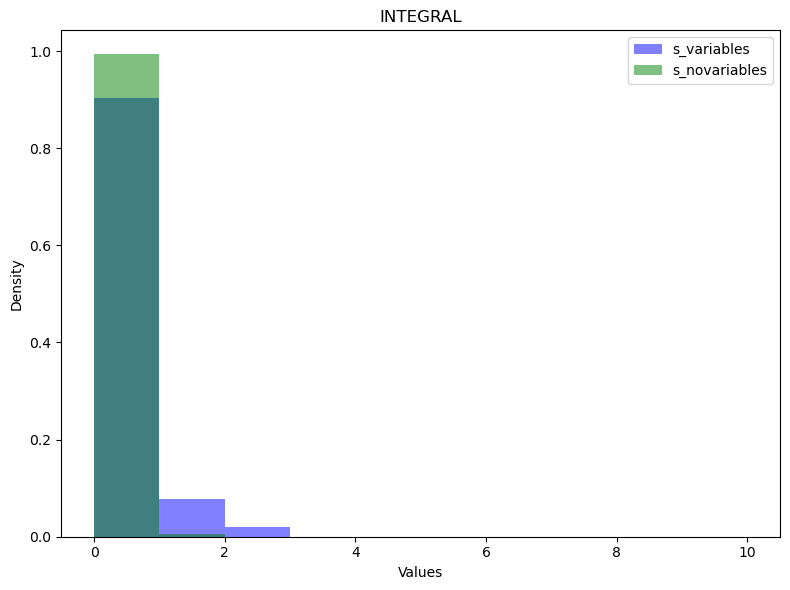

In [23]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(integrals_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables', range=(0,10))
ax.hist(integrals_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables',  range=(0,10))

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('INTEGRAL')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 9. DIFER

In [26]:
def calcular_difer(X, Y):
    N = len(X)
    diferencia_sum = sum([(Y[i] - Y[0]) / (X[i] - X[0]) for i in range(1, N - 1)])
    difer = 1 / (N - 2) * diferencia_sum
    return difer

diferencias_variables = []
for i in range(len(HJD_variable)):
    difer = calcular_difer(HJD_variable[i], variables[i])
    diferencias_variables.append(difer)

diferencias_novariables = []
for i in range(len(HJD_novariable)):
    difer = calcular_difer(HJD_novariable[i], novariables[i])
    diferencias_novariables.append(difer)
    
print(len(diferencias_variables))
print(len(diferencias_novariables))

104
306755


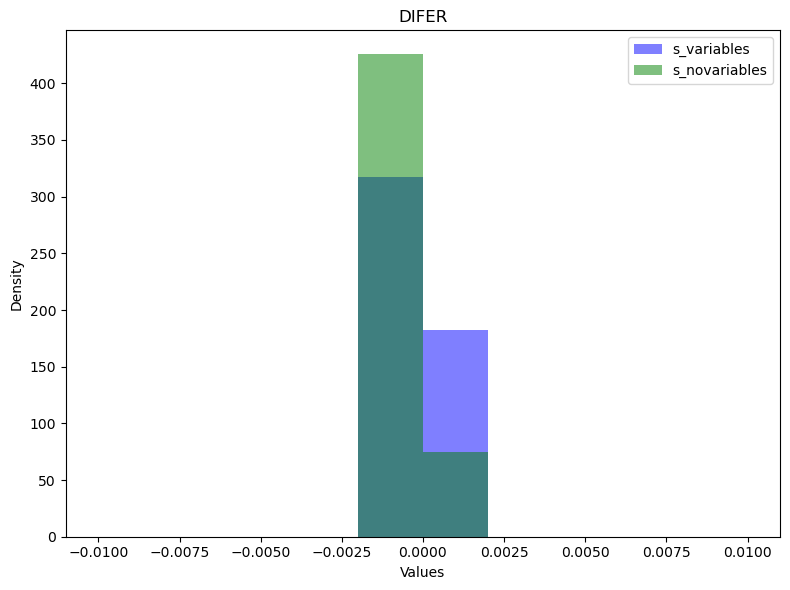

In [28]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(diferencias_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables', range=(-0.01, 0.01))
ax.hist(diferencias_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables', range=(-0.01, 0.01))

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('DIFER')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 10. RULD

In [29]:
def calcular_RULD(X, Y):
    N = len(X)
    ruld_sum = sum([((Y[i] - Y[i + 1]) / abs(Y[i] - Y[i + 1])) * (X[i + 1] - X[i]) for i in range(N - 1)])
    ruld = (1 / (N - 1)) * ruld_sum
    return ruld

rulds_variables = []
for i in range(len(HJD_variable)):
    ruld = calcular_RULD(HJD_variable[i], variables[i])
    rulds_variables.append(ruld)
    
rulds_novariables = []
for j in range(len(HJD_novariable)):
    ruld = calcular_RULD(HJD_novariable[j], novariables[j])
    rulds_novariables.append(ruld)

print(len(rulds_variables))
print(len(rulds_novariables))

C:\Users\camil\AppData\Local\Temp\ipykernel_4108\995925890.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ruld_sum = sum([((Y[i] - Y[i + 1]) / abs(Y[i] - Y[i + 1])) * (X[i + 1] - X[i]) for i in range(N - 1)])


104
306755


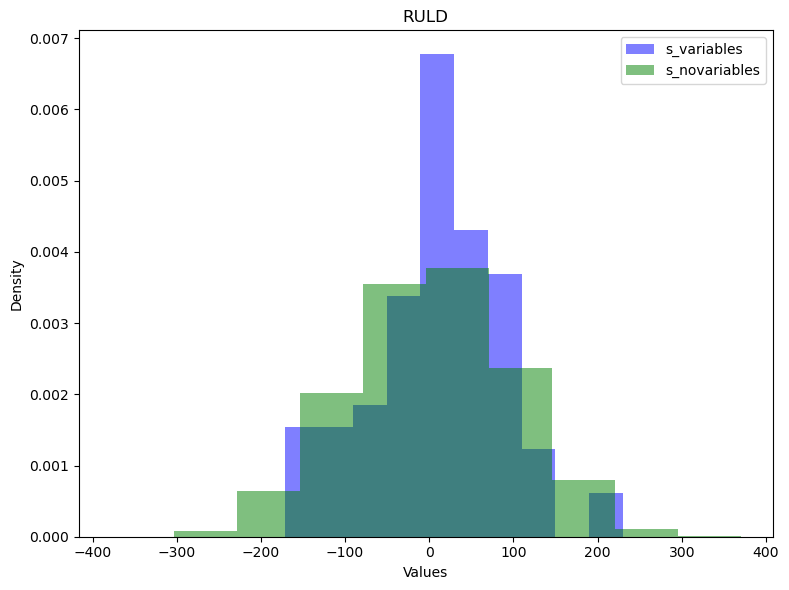

In [30]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(rulds_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(rulds_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('RULD')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# 11. Asimetria de octil (OS)

In [31]:
# Función para calcular la asimetría de octil (OS)
def calcular_os(lista):
    q1 = np.percentile(lista, 25)
    q3 = np.percentile(lista, 75)
    os = 2 * (q3 - q1) / (q3 + q1)
    return os

# Lista para almacenar los resultados de OS
os_variables = []
# Calcular OS para cada sublista en "variables" y guardar los resultados
for sublist in variables:
    os_sublist = calcular_os(sublist)
    os_variables.append(os_sublist)

# Lista para almacenar los resultados de OS
os_novariables = []
# Calcular OS para cada sublista en "variables" y guardar los resultados
for sublist in novariables:
    os_sublist = calcular_os(sublist)
    os_novariables.append(os_sublist)
    
print(len(os_variables))
print(len(os_novariables))

104
306755


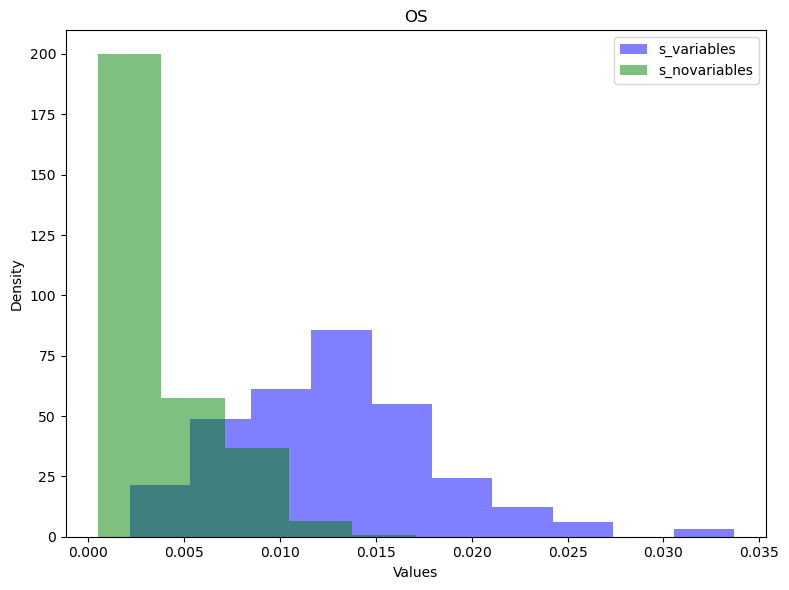

In [32]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(os_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(os_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('OS')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [34]:
# Calcular la cantidad de objetos en s_novariables antes de la superposición
threshold = np.min(os_variables)  # Se toma el valor mínimo de s_variables como umbral
s_novariables_before_overlap = np.sum(os_novariables < threshold)
print(f'Cantidad de objetos en s_novariables antes de la superposición: {s_novariables_before_overlap}')
print("Se diferencia el 48.95%")

Cantidad de objetos en s_novariables antes de la superposición: 150173
Se diferencia el 48.95%


# 12. REUCLID

In [37]:
def calcular_distancia_euclidiana(X, Y):
    N = len(X)
    distancias = [math.sqrt((X[i + 1] - X[i])**2 + (Y[i + 1] - Y[i])**2) for i in range(N - 1)]
    distancia_media = sum(distancias) / (N - 1)
    return distancia_media

rEucliDs_variables = []
for i in range(len(HJD_variable)):
    rEucliD = calcular_distancia_euclidiana(HJD_variable[i], variables[i])
    rEucliDs_variables.append(rEucliD)
    
rEucliDs_novariables = []
for j in range(len(HJD_novariable)):
    rEucliD = calcular_distancia_euclidiana(HJD_novariable[j], novariables[j])
    rEucliDs_novariables.append(rEucliD)

print(len(rEucliDs_variables))
print(len(rEucliDs_novariables))

104
306755


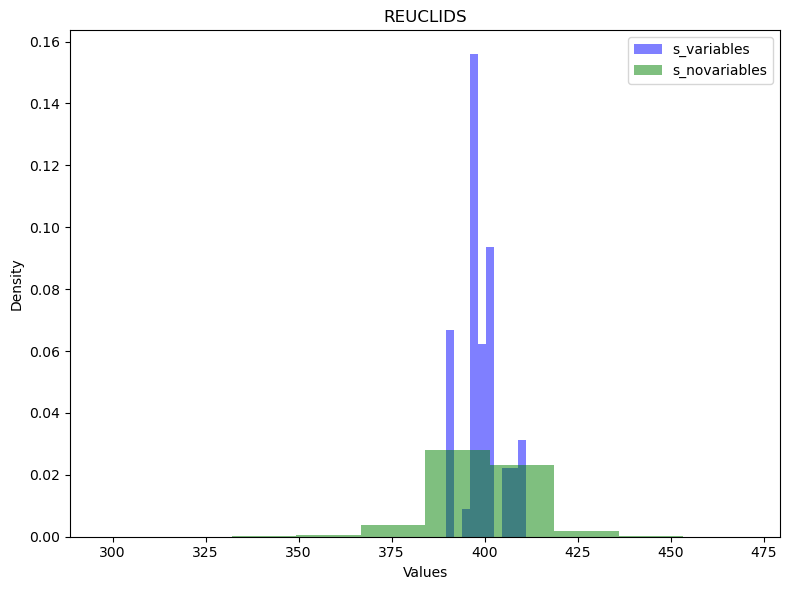

In [38]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(rEucliDs_variables, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(rEucliDs_novariables, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('REUCLIDS')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 13. Low

In [8]:
def calcular_low(s_variables, HDJ):
    # Lista para almacenar los resultados de la característica "low"
    resultados_low = []
    
    for sublist in s_variables:
        # Calcular el rango intercuartílico
        q25 = np.percentile(sublist, 25)
        q12_5 = np.percentile(sublist, 12.5)
        
        # Calcular la característica "low"
        low = ((q25 - q12_5) - (q12_5 - np.percentile(sublist, 0))) / (q25 - np.percentile(sublist, 0))
        
        # Agregar el resultado a la lista de resultados
        resultados_low.append(low)
    
    return resultados_low

resultados_low_v = calcular_low(s_variables, HJD)
resultados_low_nv = calcular_low(s_novariables, HJD)
print(len(resultados_low_v))
print(len(resultados_low_nv))

104
306755


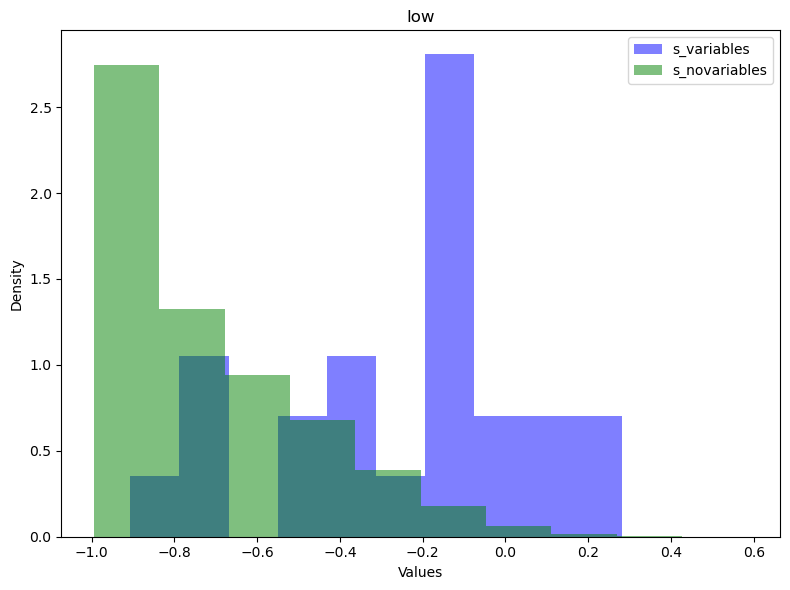

In [9]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_low_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_low_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('low')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 14. Row

In [10]:
def calcular_row(s_variables, HDJ):
    # Lista para almacenar los resultados de la característica "row"
    resultados_row = []
    
    for sublist in s_variables:
        # Calcular el rango intercuartílico
        q75 = np.percentile(sublist, 75)
        q62_5 = np.percentile(sublist, 62.5)
        
        # Calcular la característica "row"
        row = ((q75 - q62_5) - (q62_5 - np.percentile(sublist, 50))) / (q75 - np.percentile(sublist, 50))
        
        # Agregar el resultado a la lista de resultados
        resultados_row.append(row)
    
    return resultados_row

resultados_row_v = calcular_row(s_variables, HJD)
resultados_row_nv = calcular_row(s_novariables, HJD)
print(len(resultados_row_v))
print(len(resultados_row_nv))

104
306755


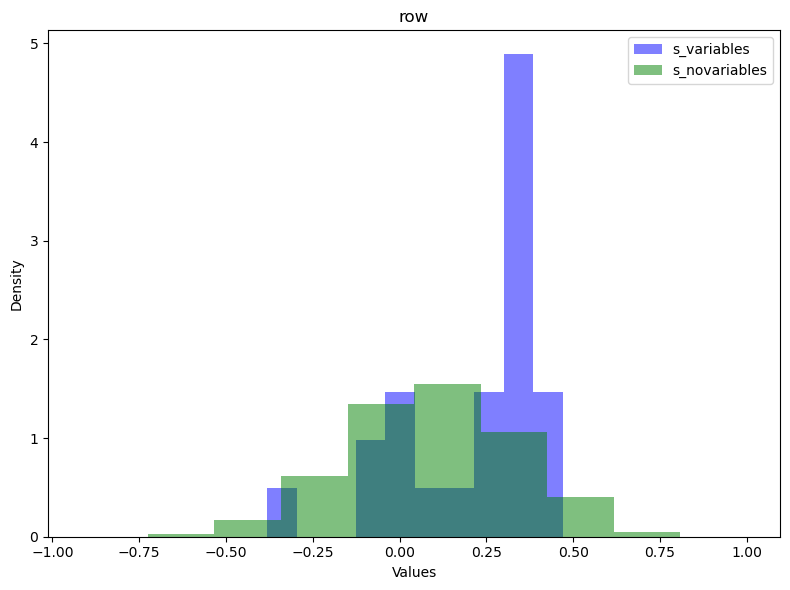

In [11]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_row_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_row_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('row')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 15. DeltaM 

In [12]:
def calcular_DeltaM(s_variables, HDJ):
    # Lista para almacenar los resultados de la característica "DeltaM"
    resultados_DeltaM = []
    
    for sublist in s_variables:
        # Calcular la característica "DeltaM"
        frac = []
        for i in range(len(HDJ) - 1):
            intervalo = [dato for dato in sublist if HDJ[i] <= dato <= HDJ[i + 1]]
            if intervalo:
                upperF = np.percentile(intervalo, 98)
                lowerF = np.percentile(intervalo, 2)
                frac.append(upperF - lowerF)
        
        # Calcular la mediana de las diferencias
        if frac:
            DeltaM = np.nanmedian(frac)
        else:
            DeltaM = np.nan  # Si no hay datos en el intervalo, asignar NaN
        
        # Agregar el resultado a la lista de resultados
        resultados_DeltaM.append(DeltaM)
    
    return resultados_DeltaM


resultados_DeltaM_v = calcular_DeltaM(s_variables, HJD)
resultados_DeltaM_nv = calcular_DeltaM(s_novariables, HJD)
print(len(resultados_DeltaM_v))
print(len(resultados_DeltaM_nv))

104
306755


## 16. Slope

In [14]:
def calcular_slope(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "slope"
    resultados_slope = []
    
    for sublist in s_variables:
        # Calcular la regresión lineal
        slope, intercept, r_value, p_value, std_err = linregress(HJD, sublist)
        
        # Agregar el resultado a la lista de resultados
        resultados_slope.append(slope)
    
    return resultados_slope

resultados_slope_v = calcular_slope(s_variables, HJD)
resultados_slope_nv = calcular_slope(s_novariables, HJD)
print(len(resultados_slope_v))
print(len(resultados_slope_nv))

104
306755


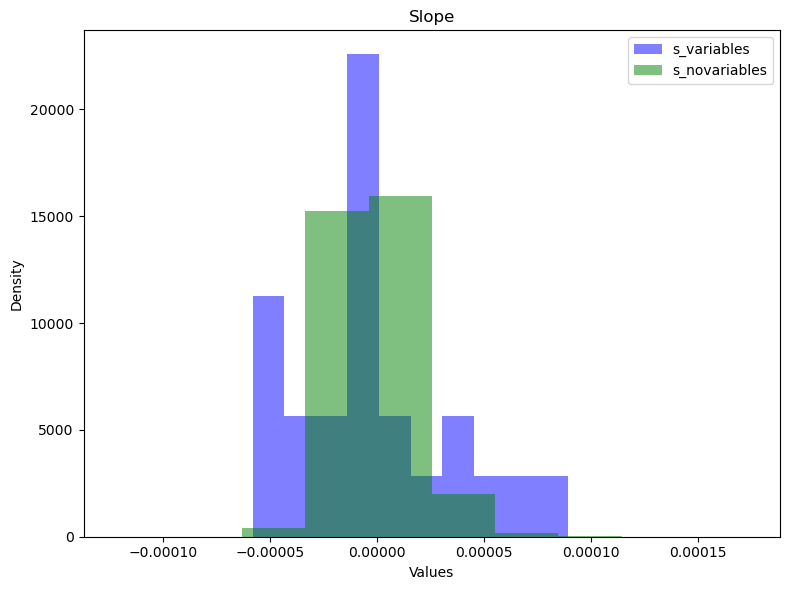

In [15]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_slope_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_slope_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('Slope')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 17. Slope_min

In [16]:
def calcular_slope_min(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "slope_min"
    resultados_slope_min = []
    
    for sublist in s_variables:
        # Inicializar la lista para almacenar las pendientes de las regresiones lineales
        slopes = []
        
        # Calcular la regresión lineal para cada subintervalo
        for i in range(len(HJD) - 1):
            # Seleccionar los datos dentro del intervalo de tiempo
            x = []
            y = []
            for j in range(len(HJD)):
                if HJD[i] <= HJD[j] <= HJD[i + 1]:
                    x.append(HJD[j])
                    y.append(sublist[j])
            
            # Calcular la regresión lineal para el subintervalo
            if len(x) > 1:
                slope, _, _, _, _ = linregress(x, y)
                slopes.append(slope)
        
        # Calcular el mínimo de las pendientes de las regresiones lineales
        if slopes:
            slope_min = min(slopes)
        else:
            slope_min = None
        
        # Agregar el resultado a la lista de resultados
        resultados_slope_min.append(slope_min)
    
    return resultados_slope_min


resultados_slope_min_v = calcular_slope_min(s_variables, HJD)
resultados_slope_min_nv = calcular_slope_min(s_novariables, HJD)
print(len(resultados_slope_min_v))
print(len(resultados_slope_min_nv))

104
306755


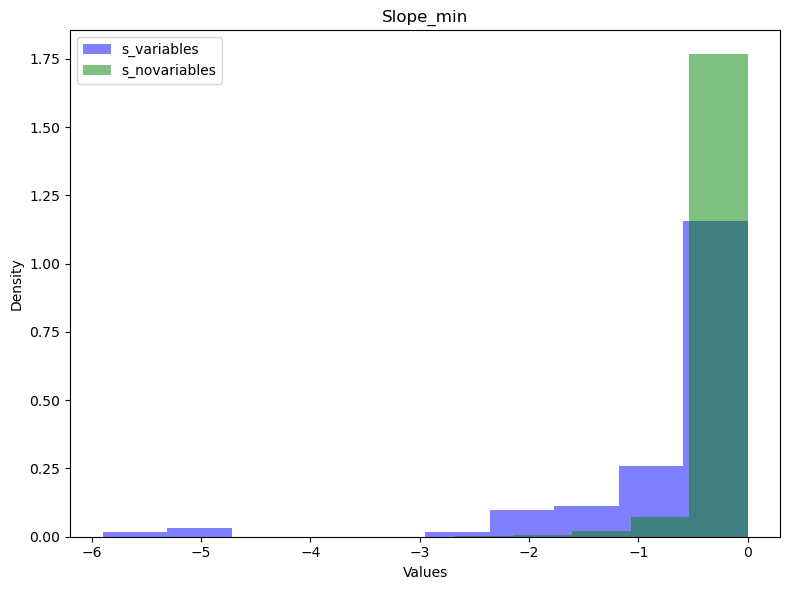

In [17]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_slope_min_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_slope_min_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('Slope_min')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 18. r_value

In [18]:
def calcular_r_value(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "r_value"
    resultados_r_value = []
    
    for sublist in s_variables:
        # Inicializar la lista para almacenar los valores de r_value de las regresiones lineales
        r_values = []
        
        # Calcular la regresión lineal para cada subintervalo
        for i in range(len(HJD) - 1):
            # Seleccionar los datos dentro del intervalo de tiempo
            x = []
            y = []
            for j in range(len(HJD)):
                if HJD[i] <= HJD[j] <= HJD[i + 1]:
                    x.append(HJD[j])
                    y.append(sublist[j])
            
            # Calcular la regresión lineal para el subintervalo
            if len(x) > 1:
                _, _, r_value, _, _ = linregress(x, y)
                r_values.append(r_value)
        
        # Calcular el promedio de los valores de r_value de las regresiones lineales
        if r_values:
            r_value_avg = sum(r_values) / len(r_values)
        else:
            r_value_avg = None
        
        # Agregar el resultado a la lista de resultados
        resultados_r_value.append(r_value_avg)
    
    return resultados_r_value


resultados_r_value_v = calcular_r_value(s_variables, HJD)
resultados_r_value_nv = calcular_r_value(s_novariables, HJD)
print(len(resultados_r_value_v))
print(len(resultados_r_value_nv))

104
306755


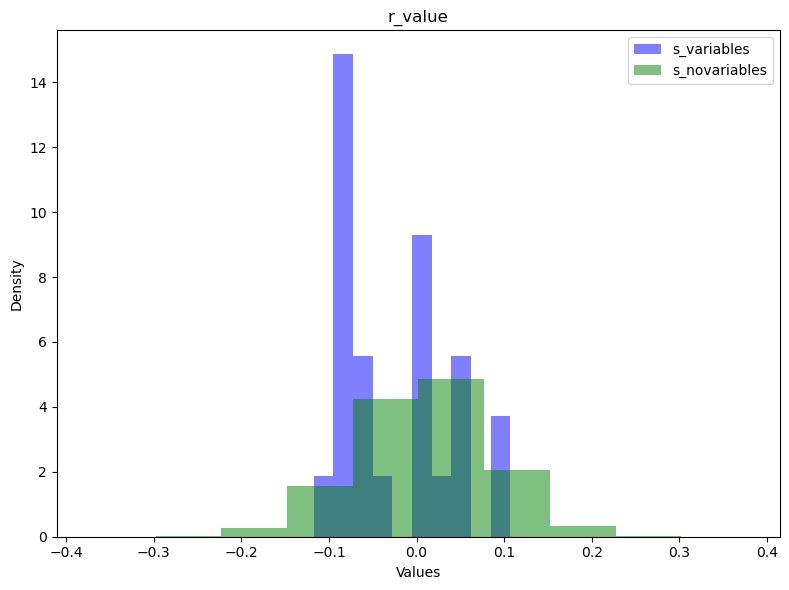

In [19]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_r_value_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_r_value_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('r_value')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 19. r_val_min

In [20]:
def calcular_r_value_min(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "r_value_min"
    resultados_r_value_min = []
    
    for sublist in s_variables:
        # Inicializar la lista para almacenar los valores de r_value de las regresiones lineales
        r_values = []
        
        # Calcular la regresión lineal para cada subintervalo
        for i in range(len(HJD) - 1):
            # Seleccionar los datos dentro del intervalo de tiempo
            x = []
            y = []
            for j in range(len(HJD)):
                if HJD[i] <= HJD[j] <= HJD[i + 1]:
                    x.append(HJD[j])
                    y.append(sublist[j])
            
            # Calcular la regresión lineal para el subintervalo
            if len(x) > 1:
                _, _, r_value, _, _ = linregress(x, y)
                r_values.append(r_value)
        
        # Calcular el mínimo de los valores de r_value de las regresiones lineales
        if r_values:
            r_value_min = min(r_values)
        else:
            r_value_min = None
        
        # Agregar el resultado a la lista de resultados
        resultados_r_value_min.append(r_value_min)
    
    return resultados_r_value_min


resultados_r_value_min_v = calcular_r_value_min(s_variables, HJD)
resultados_r_value_min_nv = calcular_r_value_min(s_novariables, HJD)
print(len(resultados_r_value_min_v))
print(len(resultados_r_value_min_nv))

104
306755


## 20. eta

In [21]:
def calcular_eta(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "eta"
    resultados_eta = []
    
    for sublist in s_variables:
        # Calcular el numerador de la característica "eta"
        numerador = sum([(y2 - y1)**2 for y1, y2 in zip(sublist[:-1], sublist[1:])])
        
        # Calcular el denominador de la característica "eta"
        denominador = sum([(y - np.mean(sublist))**2 for y in sublist])
        
        # Calcular la característica "eta"
        if denominador != 0:
            eta = numerador / denominador
        else:
            eta = None
        
        # Agregar el resultado a la lista de resultados
        resultados_eta.append(eta)
    
    return resultados_eta


resultados_eta_v = calcular_eta(s_variables, HJD)
resultados_eta_nv = calcular_eta(s_novariables, HJD)
print(len(resultados_eta_v))
print(len(resultados_eta_nv))

104
306755


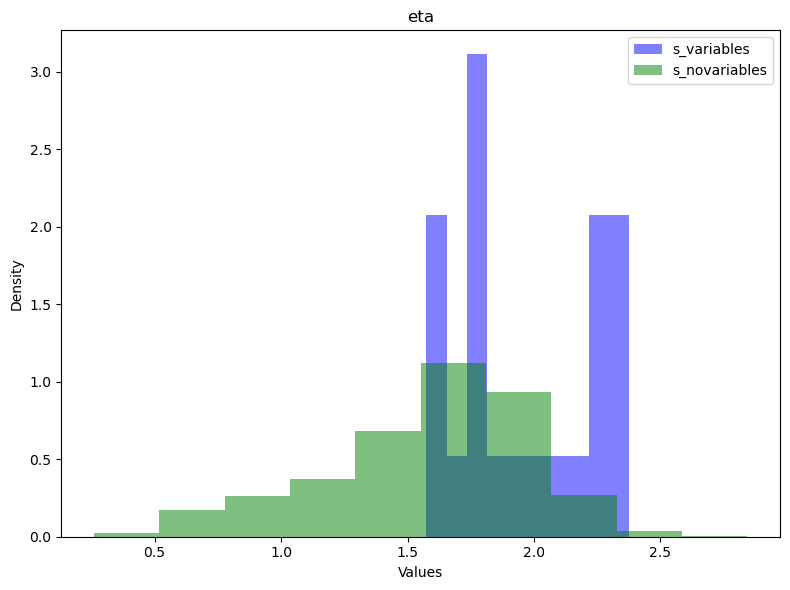

In [22]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_eta_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_eta_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('eta')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 21. reDSign

In [23]:
def calcular_reDSign(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "reDSign"
    resultados_reDSign = []
    
    for sublist in s_variables:
        # Calcular las diferencias entre puntos consecutivos
        diffs = [y2 - y1 for y1, y2 in zip(sublist[:-1], sublist[1:])]
        
        # Calcular las diferencias signadas
        signos = [np.sign(diff) for diff in diffs]
        
        # Calcular el producto de las diferencias signadas y el signo de la pendiente
        reDSign = np.median([signo * np.sign(sublist[-1] - sublist[0]) for signo in signos])
        
        # Agregar el resultado a la lista de resultados
        resultados_reDSign.append(reDSign)
    
    return resultados_reDSign


resultados_reDSign_v = calcular_reDSign(s_variables, HJD)
resultados_reDSign_nv = calcular_reDSign(s_variables, HJD)
print(resultados_reDSign_v)
print(resultados_reDSign_nv)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, -1.0, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, -1.0, nan, nan, 1.0, nan, nan, nan, nan, 1.0, nan, nan, nan, 1.0, -1.0, nan, nan, nan, nan, -1.0, -1.0, -1.0, -1.0, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, 1.0, nan, nan, nan, -1.0, 1.0, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, 1.0, 1.0, nan, nan, nan, nan, -1.0, nan, nan, nan, 1.0, -1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, -1.0, nan, nan, nan, 1.0, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, -1.0, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, -1.0, nan, nan, 1.0, nan, nan, nan, nan, 1.0, nan, nan, nan, 1.0, -1.0, nan, nan, nan, nan, -1.0, -1.0, -1.0, -1.0, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, 1.0, nan, nan, nan, -1.0, 1.0, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, 1.0, 1.0, nan, nan, nan, nan, -1.0, nan, nan, nan, 1.0, -1.0, nan, nan, nan, nan, nan, nan, na

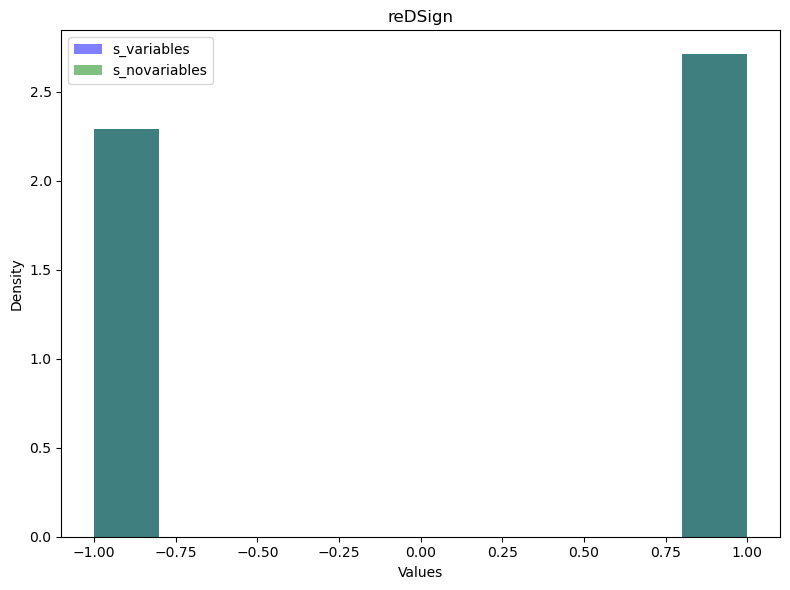

In [24]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_reDSign_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_reDSign_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('reDSign')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 22. rbLeon

In [25]:
def calcular_rbLeon(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "rbLeon"
    resultados_rbLeon = []
    
    for sublist in s_variables:
        # Calcular las diferencias entre puntos consecutivos
        diffs = [y2 - y1 for y1, y2 in zip(sublist[:-1], sublist[1:])]
        
        # Calcular la mediana de las diferencias absolutas
        rbLeon = np.median(np.abs(diffs))
        
        # Agregar el resultado a la lista de resultados
        resultados_rbLeon.append(rbLeon)
    
    return resultados_rbLeon


resultados_rbLeon_v = calcular_rbLeon(s_variables, HJD)
resultados_rbLeon_nv = calcular_rbLeon(s_novariables, HJD)
print(len(resultados_rbLeon_v))
print(len(resultados_rbLeon_nv))def calcular_rbLeon(s_variables, HJD):
    # Lista para almacenar los resultados de la característica "rbLeon"
    resultados_rbLeon = []
    
    for sublist in s_variables:
        # Calcular las diferencias entre puntos consecutivos
        diffs = [y2 - y1 for y1, y2 in zip(sublist[:-1], sublist[1:])]
        
        # Calcular la mediana de las diferencias absolutas
        rbLeon = np.median(np.abs(diffs))
        
        # Agregar el resultado a la lista de resultados
        resultados_rbLeon.append(rbLeon)
    
    return resultados_rbLeon


resultados_rbLeon_v = calcular_rbLeon(s_variables, HJD)
resultados_rbLeon_nv = calcular_rbLeon(s_novariables, HJD)
print(len(resultados_rbLeon_v))
print(len(resultados_rbLeon_nv))

SyntaxError: invalid syntax (1856872715.py, line 21)

In [ ]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_rbLeon_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_rbLeon_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('rbLeon')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 23. rbLeon_sing

In [ ]:
def calcular_rbLeon_sign(s_variables):
    # Lista para almacenar los resultados de la característica "rbLeon_sign"
    resultados_rbLeon_sign = []
    
    for sublist in s_variables:
        # Calcular las diferencias entre puntos consecutivos
        diffs = [y2 - y1 for y1, y2 in zip(sublist[:-1], sublist[1:])]
        
        # Calcular el signo de las diferencias
        signos_diffs = [np.sign(diff) for diff in diffs]
        
        # Calcular la mediana de los signos de las diferencias
        rbLeon_sign = np.median(signos_diffs)
        
        # Agregar el resultado a la lista de resultados
        resultados_rbLeon_sign.append(rbLeon_sign)
    
    return resultados_rbLeon_sign


resultados_rbLeon_sign_v = calcular_rbLeon_sign(s_variables)
resultados_rbLeon_sign_nv = calcular_rbLeon_sign(s_novariables)
print(resultados_rbLeon_sign_v)
print(resultados_rbLeon_sign_nv)

In [ ]:
# Crear la figura y los subgráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar histogramas en el mismo gráfico
ax.hist(resultados_rbLeon_sign_v, bins=10, color='blue', alpha=0.5, density=True, label='s_variables')
ax.hist(resultados_rbLeon_sign_nv, bins=10, color='green', alpha=0.5, density=True, label='s_novariables')

# Agregar leyenda y título al gráfico
ax.legend()
ax.set_title('rbLeon_sign')
ax.set_xlabel('Values')
ax.set_ylabel('Density')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()